# Step 0: Environment & Libraries
Before anything else, let's start by importing the necessary libraries for this project

In [1]:
# Basic Data Handling
import numpy as np
import pandas as pd
import json
import os
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, GRU  # For RNN models

# For progress tracking during preprocessing
from tqdm import tqdm

# For hyperparameter tuning with Keras Tuner
import keras_tuner as kt



### Setting random seed for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### To work with stopwords 

In [3]:
# Download NLTK resources if not already present
nltk.download('stopwords')
nltk.download('punkt')

# Load stopwords and spaCy English model (uncomment the download command if needed)
stop_words = set(nltk.corpus.stopwords.words('english'))

# Run this line if you haven't downloaded the model yet
!python -m spacy download en_core_web_sm  

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 7.1 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.8 MB 8.0 MB/s eta 0:00:02
     ------------- -------------------------- 4.5/12.8 MB 7.7 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 7.3 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.8 MB 7.3 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 7.3 MB/s eta 0:00:01
     ------------------------------- -------- 10.2/12.8 MB 7.2 MB/s eta 0:00:01
     ------------------------------------ --- 11.8/12.8 MB 7.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Step 1: Data Ingestion & Initial Preprocessing

### 1.1 Load JSON Data and Create DataFrame

In [4]:
# Load JSON lines from data directory
data = []
with open('../data/news_category_dataset.json', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### 1.2 Combine Text Columns

In [5]:
# If both headline and short_description are present:
df['text'] = df['headline'].fillna('') + ' ' + df['short_description'].fillna('')

### 1.3 Encode Categories as Numeric Labels

In [6]:
# If you have named categories (e.g., "COMEDY", "U.S. NEWS")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])  # or df['Class Index'] if CSV has numbers

# View label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_map)

# Show updated dataframe
df[['text', 'category', 'label']].head()


{'ARTS': np.int64(0), 'ARTS & CULTURE': np.int64(1), 'BLACK VOICES': np.int64(2), 'BUSINESS': np.int64(3), 'COLLEGE': np.int64(4), 'COMEDY': np.int64(5), 'CRIME': np.int64(6), 'CULTURE & ARTS': np.int64(7), 'DIVORCE': np.int64(8), 'EDUCATION': np.int64(9), 'ENTERTAINMENT': np.int64(10), 'ENVIRONMENT': np.int64(11), 'FIFTY': np.int64(12), 'FOOD & DRINK': np.int64(13), 'GOOD NEWS': np.int64(14), 'GREEN': np.int64(15), 'HEALTHY LIVING': np.int64(16), 'HOME & LIVING': np.int64(17), 'IMPACT': np.int64(18), 'LATINO VOICES': np.int64(19), 'MEDIA': np.int64(20), 'MONEY': np.int64(21), 'PARENTING': np.int64(22), 'PARENTS': np.int64(23), 'POLITICS': np.int64(24), 'QUEER VOICES': np.int64(25), 'RELIGION': np.int64(26), 'SCIENCE': np.int64(27), 'SPORTS': np.int64(28), 'STYLE': np.int64(29), 'STYLE & BEAUTY': np.int64(30), 'TASTE': np.int64(31), 'TECH': np.int64(32), 'THE WORLDPOST': np.int64(33), 'TRAVEL': np.int64(34), 'U.S. NEWS': np.int64(35), 'WEDDINGS': np.int64(36), 'WEIRD NEWS': np.int64(37

,text,category,label
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,35
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,35
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,5
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,22
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,35


### 1.4 Save the Full Cleaned Dataset

In [7]:
df.to_csv("cleaned_dataset.csv", index=False)

# Step 2: Exploratory Data Analysis (EDA)

### 2.1 Plot Class Distribution for Top 15 Categories

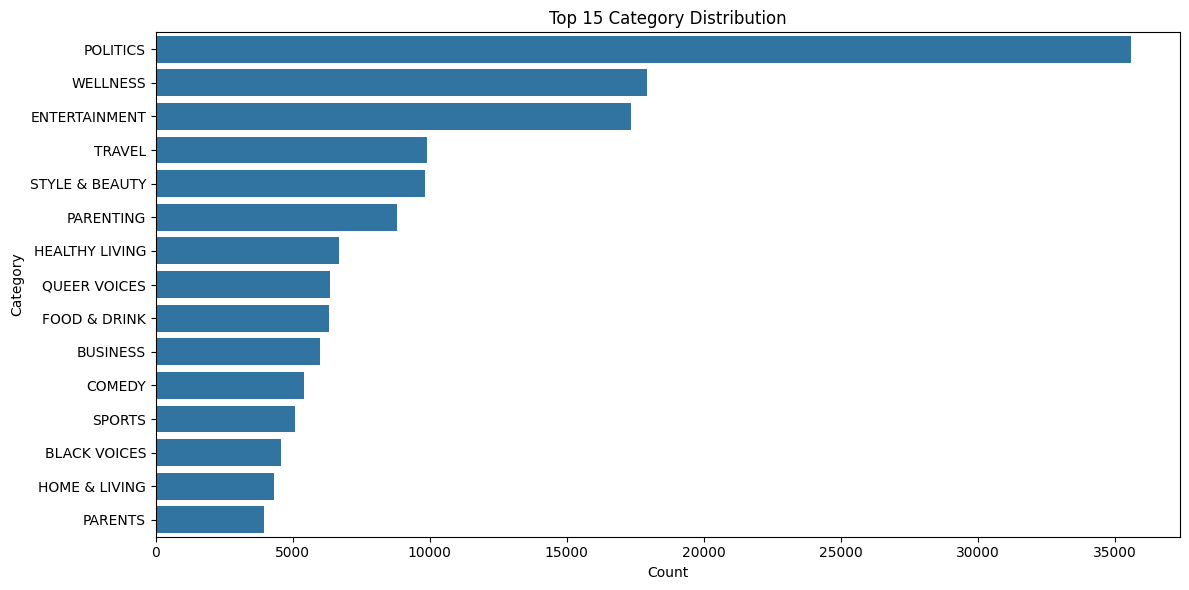

Number of categories: 42
Normalized category counts:
 category
POLITICS          0.169916
WELLNESS          0.085645
ENTERTAINMENT     0.082863
TRAVEL            0.047249
STYLE & BEAUTY    0.046839
Name: proportion, dtype: float64


In [8]:
# Count categories
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='category', order=df['category'].value_counts().index[:15])
plt.title("Top 15 Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# Optional: print class imbalance stats
print("Number of categories:", df['category'].nunique())
# print(df['category'].value_counts(normalize=True).head()) --> ???
print("Normalized category counts:\n", df['category'].value_counts(normalize=True).head())


### 2.2 Check for Missing Values

In [9]:
# Missing values summary
print("Missing Values:\n", df.isnull().sum())

# Distribution of empty texts
print("Empty text rows:", (df['text'].str.strip() == '').sum())


Missing Values:
 link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
text                 0
label                0
dtype: int64
Empty text rows: 5


### 2.3 Analyze Text Length (Word Count)

Word Count Stats:
 count    209527.000000
mean         29.269770
std          13.803927
min           0.000000
25%          20.000000
50%          28.000000
75%          35.000000
max         245.000000
Name: word_count, dtype: float64


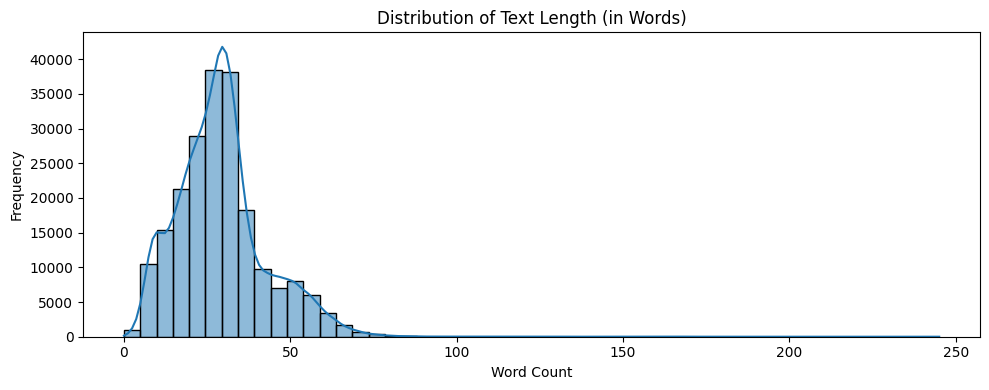

In [10]:
# Add basic length stats
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Summary stats
print("Word Count Stats:\n", df['word_count'].describe())

# Histogram of word counts
plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Text Length (in Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 2.4 Average Word Count by Category

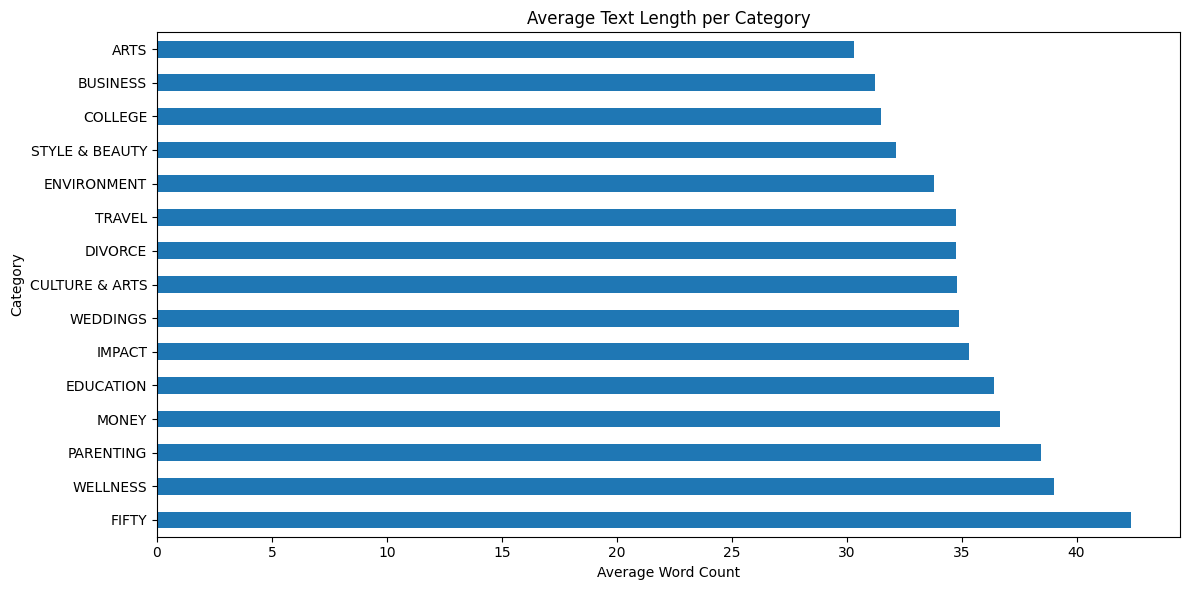

In [11]:
# Average length per category
category_wc = df.groupby('category')['word_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
category_wc.head(15).plot(kind='barh')
plt.title("Average Text Length per Category")
plt.xlabel("Average Word Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


### 2.5 Display Example Snippets by Category

In [12]:
# Show 1 example per category
example_snippets = df.groupby('category')['text'].apply(lambda x: x.sample(1).values[0])
for cat, text in example_snippets.items():
    print(f"--- {cat} ---")
    print(text[:300], '...\n')


--- ARTS ---
Demiurge I have now and then heard artists likened to the demiurge - Plato's word for the divinity that made the cosmos. This never made a visceral impression on me until I saw how Assael paints. He summons an image the way the Genesis demiurge summons the universe. ...

--- ARTS & CULTURE ---
11 Republican Lawmakers Sign Letter In Support Of Arts Funding Arts advocates have relied on bipartisan support for the endowments in the past, and it may see them through again. ...

--- BLACK VOICES ---
Obama Names Kendrick Lamar Song As His Favorite Of 2015, Becomes Coolest President Ever Michelle locks down the title of coolest First Lady, too. ...

--- BUSINESS ---
Obama Ridiculed For Sluggish Moves On College Accreditation The Education Department has the power to put dodgy accreditors out of business, but won't use it. ...

--- COLLEGE ---
A Modest Proposal to Halt Rising Tuition Costs  ...

--- COMEDY ---
20 Times You May Have Seen Patton Oswalt And Not Realized It  ...

--- 

# Step 3: Text Preprocessing using spaCy

### 3.1 Define a basic cleaning function to lowercase and remove non-letter characters

In [13]:
def clean_for_spacy(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

### 3.2 Fast preprocessing using spaCy's nlp.pipe for lemmatization

In [14]:
def fast_preprocess(texts):
    cleaned_texts = [clean_for_spacy(t) for t in texts]
    docs = nlp.pipe(cleaned_texts, batch_size=64)
    return [
        ' '.join(
            token.lemma_ for token in doc 
            if token.lemma_ not in stop_words and len(token) > 2 and not token.is_stop and not token.is_punct
        )
        for doc in docs
    ]

### 3.3 Choose Dataset Version

In [15]:
# Option 1: Process the full dataset (this is very slow, it took me 8 hours to run...)
# df['clean_text'] = fast_preprocess(df['text'])

# Option 2: Use a 50k-row sample for faster processing
df_sample = df.sample(n=50000, random_state=42).copy()

### 3.4 Enhanced preprocessing with tqdm progress tracking

In [16]:
def fast_preprocess_with_tqdm(texts):
    cleaned_texts = [clean_for_spacy(t) for t in texts]
    docs = list(tqdm(nlp.pipe(cleaned_texts, batch_size=64), total=len(cleaned_texts)))
    results = []
    for doc in docs:
        tokens = [
            token.lemma_ for token in doc
            if len(token) > 2 and token.is_alpha and not token.is_stop and token.lemma_ not in stop_words
        ]
        results.append(' '.join(tokens))
    return results

df_sample['clean_text'] = fast_preprocess_with_tqdm(df_sample['text'])

100%|██████████| 50000/50000 [09:14<00:00, 90.11it/s] 


### 3.5 Save the preprocessed sample for future use

In [17]:
df_sample.to_csv("cleaned_sample_dataset.csv", index=False)

### 3.6 Check Most Common Words

In [20]:
# Combine all tokens
all_tokens = ' '.join(df_sample['clean_text']).split()
common_words = Counter(all_tokens).most_common(20)

# Display
print("Most common words:", common_words)


Most common words: [('new', 4814), ('trump', 4550), ('say', 3872), ('photo', 3506), ('day', 3429), ('year', 3369), ('time', 3302), ('people', 2972), ('good', 2930), ('like', 2930), ('know', 2645), ('life', 2616), ('way', 2558), ('want', 2421), ('look', 2206), ('world', 2187), ('woman', 2182), ('love', 2136), ('find', 2109), ('come', 2073)]


# Step 4: Data Splitting (Train/Validation/Test)

In [21]:
# Step 0: Use the sample dataset for subsequent modeling
sample_df = df_sample.copy()

# Step 1: Split into train (70%) and temp (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    sample_df['clean_text'], sample_df['label'], 
    test_size=0.30, 
    stratify=sample_df['label'], 
    random_state=42
)

# Step 2: Split temp into validation (15%) and test (15%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, 
    test_size=0.50, 
    stratify=temp_labels, 
    random_state=42
)

# Confirm proportions
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")


Training samples: 35000
Validation samples: 7500
Test samples: 7500


### Wrap into DataFrames for easier handling

In [22]:
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# Step 5: Baseline Model – TF-IDF + PCA + Linear SVM

### 5.1 TF-IDF Vectorization

In [23]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # Use unigrams and bigrams
    max_features=10000,      # Limit vocabulary size
    min_df=5,                # Ignore rare words
    max_df=0.8,              # Ignore overly common words
)

# Fit on training set only
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_val_tfidf = tfidf.transform(val_df['text'])
X_test_tfidf = tfidf.transform(test_df['text'])

# Labels
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

### 5.2 Dimensionality Reduction with PCA on TF-IDF Vectors 

In [24]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=300, random_state=42)

# PCA requires dense arrays
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_val_pca = pca.transform(X_val_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())


### 5.3 Train a Linear SVM with GridSearchCV

In [25]:
# SVM model
svm = LinearSVC(max_iter=5000)

# Hyperparameter grid
param_grid = {'C': [0.01, 0.1, 1, 10]}

# Grid Search on validation split
grid = GridSearchCV(svm, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid.fit(X_train_pca, y_train)

# Best model
best_svm = grid.best_estimator_
print("Best C:", grid.best_params_['C'])


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best C: 10


### 5.4 Evaluate the SVM Model on the Test Set

SVM Test Accuracy: 0.49533333333333335
SVM Test F1 Score (weighted): 0.438311838766969

SVM Classification Report:
                 precision    recall  f1-score   support

          ARTS       0.27      0.11      0.16        53
ARTS & CULTURE       0.25      0.06      0.10        47
  BLACK VOICES       0.40      0.17      0.24       163
      BUSINESS       0.39      0.29      0.33       214
       COLLEGE       0.30      0.24      0.26        34
        COMEDY       0.44      0.14      0.21       185
         CRIME       0.39      0.46      0.42       130
CULTURE & ARTS       0.43      0.08      0.14        37
       DIVORCE       0.76      0.62      0.68       120
     EDUCATION       0.47      0.24      0.32        37
 ENTERTAINMENT       0.41      0.67      0.51       610
   ENVIRONMENT       0.38      0.15      0.21        55
         FIFTY       0.00      0.00      0.00        49
  FOOD & DRINK       0.59      0.70      0.64       225
     GOOD NEWS       0.23      0.06      0.

c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

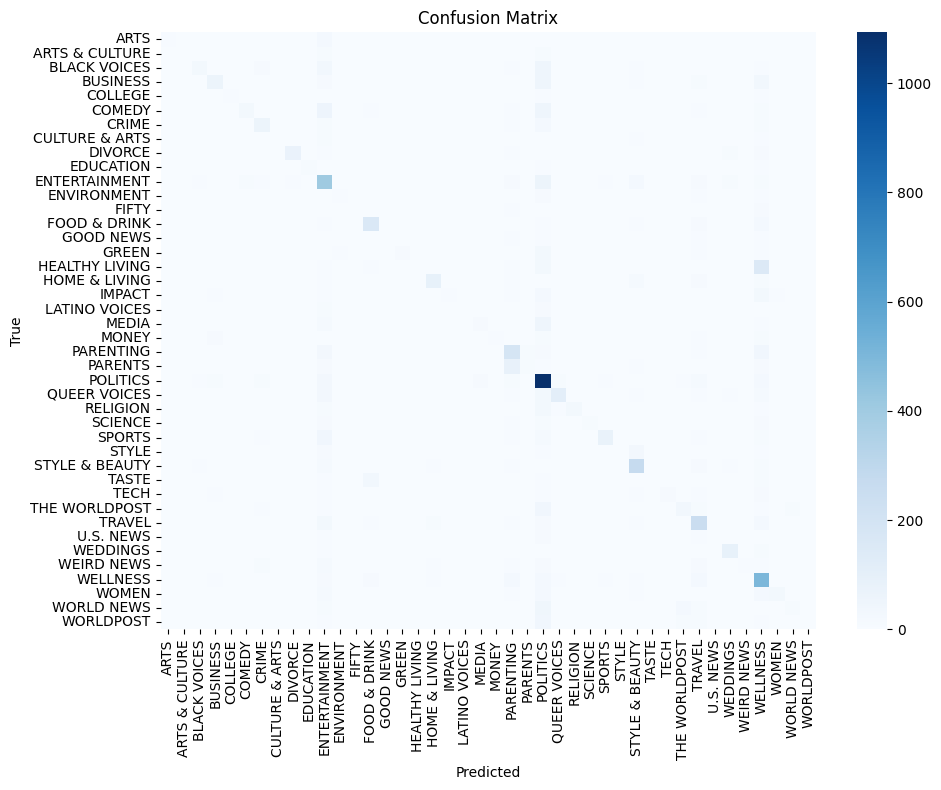

In [26]:
# Predict
y_pred = best_svm.predict(X_test_pca)

# Metrics
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=False, 
            cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# Step 6: Deep Learning Model – CNN for Text Classification

### 6.1 Tokenization & Sequence Preparation

In [27]:
# Parameters
MAX_NUM_WORDS = 20000   # limit vocab size
MAX_SEQUENCE_LENGTH = 200  # pad/truncate text to 200 tokens

# Tokenize and convert to sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

# Convert texts to padded sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=MAX_SEQUENCE_LENGTH)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['text']), maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=MAX_SEQUENCE_LENGTH)

# Labels
y_train_cat = tf.keras.utils.to_categorical(train_df['label'])
y_val_cat = tf.keras.utils.to_categorical(val_df['label'])
y_test_cat = tf.keras.utils.to_categorical(test_df['label'])

# Get basic values
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
num_classes = y_train_cat.shape[1]


### 6.2 Load Pretrained GloVe Embeddings

In [28]:
# Load GloVe file (download e.g. glove.6B.100d.txt from https://nlp.stanford.edu/projects/glove/)
embedding_dim = 100
embedding_index = {}

with open('../data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 6.3 Define and Compile the CNN Model

In [31]:
cnn_model = Sequential()
cnn_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],   # use this only if loading GloVe
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False               # set True if you want fine-tuning
))
              
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

cnn_model.summary()


c:\MLProject\news_classification_project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

### 6.4 Train the CNN Model with Early Stopping

In [32]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit
history = cnn_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.2894 - loss: 2.9090 - val_accuracy: 0.4792 - val_loss: 1.9830
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.4440 - loss: 2.1337 - val_accuracy: 0.5084 - val_loss: 1.8229
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.4797 - loss: 1.9601 - val_accuracy: 0.5197 - val_loss: 1.7748
Epoch 4/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.5008 - loss: 1.8435 - val_accuracy: 0.5252 - val_loss: 1.7440
Epoch 5/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5171 - loss: 1.7652 - val_accuracy: 0.5320 - val_loss: 1.7293
Epoch 6/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5248 - loss: 1.7117 - val_accuracy: 0.5296 - val_loss: 1.7315
Epoch 7/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.5386 - loss: 1.6535 - val_accuracy: 0.5287 - val_loss: 1.7411
Epoch 8/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5487 -

### 6.5 Evaluate Performance

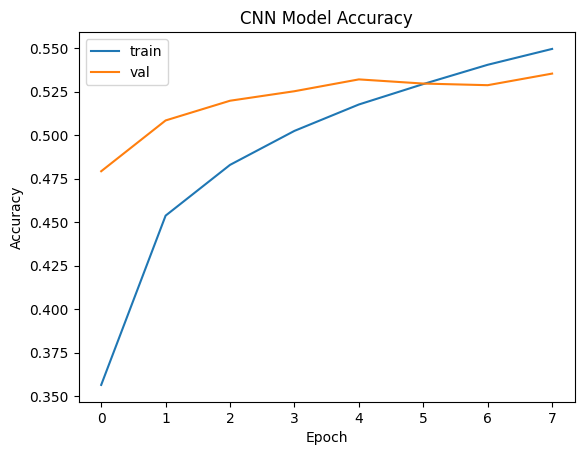

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

CNN Classification Report:
                 precision    recall  f1-score   support

          ARTS       0.38      0.09      0.15        53
ARTS & CULTURE       0.00      0.00      0.00        47
  BLACK VOICES       0.39      0.12      0.18       163
      BUSINESS       0.33      0.38      0.35       214
       COLLEGE       0.00      0.00      0.00        34
        COMEDY       0.57      0.09      0.15       185
         CRIME       0.42      0.57      0.49       130
CULTURE & ARTS       0.44      0.11      0.17        37
       DIVORCE       0.72      0.61      0.66       120
     EDUCATION       0.46      0.16      0.24        37
 ENTERTAINMENT       0.48      0.71      0.57       610
   ENVIRONMENT       0.43      0.18      0.26        55
         FIFTY       0.00      0.00      0.00        49
  FOOD & DRINK       0.57      0.77      0.66       225
     GOOD NEWS       0.00      0.00      0.00        49
         GREEN       0.38      0.27      0.32        95
HEALTHY LIVING     

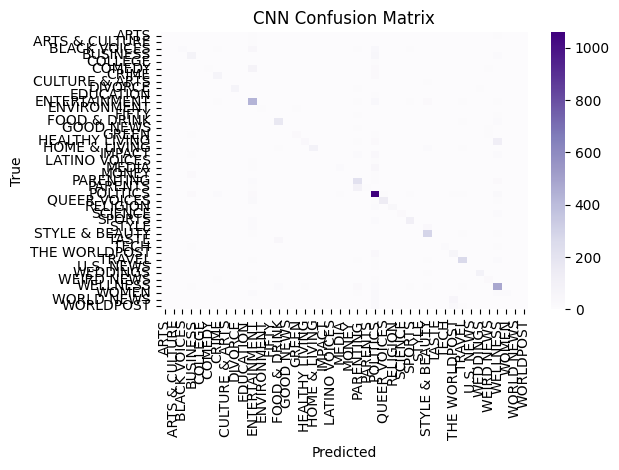

In [33]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions
y_pred_cnn = cnn_model.predict(X_test_seq).argmax(axis=1)

# Evaluation
print("CNN Classification Report:\n", 
      classification_report(test_df['label'], y_pred_cnn, target_names=label_encoder.classes_))


# Confusion matrix
sns.heatmap(confusion_matrix(test_df['label'], y_pred_cnn), 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            annot=False, cmap="Purples")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 7: Additional Models – RNN (LSTM & GRU)

### 7.1 LSTM Model

In [34]:
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                         weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                         trainable=False))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

lstm_model.summary()

# Train & Evaluate (same as CNN)
history_lstm = lstm_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=15,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

c:\MLProject\news_classification_project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 245s 216ms/step - accuracy: 0.3027 - loss: 2.8030 - val_accuracy: 0.4619 - val_loss: 2.0030
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 208s 190ms/step - accuracy: 0.4575 - loss: 2.0392 - val_accuracy: 0.5004 - val_loss: 1.8417
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14983s 14s/step - accuracy: 0.4901 - loss: 1.8880 - val_accuracy: 0.5189 - val_loss: 1.7602
Epoch 4/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 206s 188ms/step - accuracy: 0.5106 - loss: 1.7987 - val_accuracy: 0.5289 - val_loss: 1.7050
Epoch 5/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 259s 237ms/step - accuracy: 0.5253 - loss: 1.7371 - val_accuracy: 0.5417 - val_loss: 1.6636
Epoch 6/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 264s 241ms/step - accuracy: 0.5370 - loss: 1.6843 - val_accuracy: 0.5461 - val_loss: 1.6586
Epoch 7/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 296s 217ms/step - accuracy: 0.5507 - loss: 1.6425 - val_accuracy: 0.5469 - val_loss: 1.6504
Epoch 8/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 259s 237ms/step - ac

### 7.2 GRU Model

In [35]:
gru_model = Sequential()

gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

gru_model.summary()

# Train and Evaluate (same as CNN and LSTM)
history_gru = gru_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=15,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 257s 227ms/step - accuracy: 0.2801 - loss: 2.8843 - val_accuracy: 0.4700 - val_loss: 1.9896
Epoch 2/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 243s 222ms/step - accuracy: 0.4637 - loss: 2.0301 - val_accuracy: 0.5031 - val_loss: 1.7991
Epoch 3/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 265s 242ms/step - accuracy: 0.4965 - loss: 1.8622 - val_accuracy: 0.5180 - val_loss: 1.7341
Epoch 4/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 250s 229ms/step - accuracy: 0.5166 - loss: 1.7711 - val_accuracy: 0.5340 - val_loss: 1.6793
Epoch 5/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 249s 228ms/step - accuracy: 0.5317 - loss: 1.7154 - val_accuracy: 0.5416 - val_loss: 1.6491
Epoch 6/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 233s 212ms/step - accuracy: 0.5399 - loss: 1.6718 - val_accuracy: 0.5492 - val_loss: 1.6289
Epoch 7/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 251s 229ms/step - accuracy: 0.5455 - loss: 1.6316 - val_accuracy: 0.5491 - val_loss: 1.6217
Epoch 8/15
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 257s 235ms/step - ac

## Step 8: Hyperparameter Tuning with Keras Tuner (CNN Model)

### 8.1 Build Searchable CNN Model

In [36]:
### Install Keras Tuner (if not already)
# pip install keras-tuner --quiet 

def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', [50, 100, 200]),
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True
    ))
    
    model.add(Conv1D(filters=hp.Int('filters', 64, 256, step=64),
                     kernel_size=hp.Choice('kernel_size', [3, 4, 5]),
                     activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    
    return model


### 8.2 Run the Hyperparameter Search

In [37]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_text_classification'
)

tuner.search(X_train_seq, y_train_cat,
             epochs=10,
             validation_data=(X_val_seq, y_val_cat),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Trial 10 Complete [00h 04m 00s]
val_accuracy: 0.5178666710853577

Best val_accuracy So Far: 0.5350666642189026
Total elapsed time: 00h 36m 51s


### 8.3 Get Best Model

In [38]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:", best_hp.values)

best_model_tuned = tuner.get_best_models(1)[0]
best_model_tuned.evaluate(X_test_seq, y_test_cat)

Best Hyperparameters: {'embedding_dim': 100, 'filters': 192, 'kernel_size': 5, 'dropout': 0.3, 'dense_units': 128}


c:\MLProject\news_classification_project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5412 - loss: 1.7732


[1.7952402830123901, 0.5345333218574524]

# Step 9: Final Model Evaluation & Comparison

### 9.1 Evaluate and compare the SVM and tuned CNN models

235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
SVM Accuracy: 0.49533333333333335
CNN (Tuned) Accuracy: 0.5345333333333333

SVM Classification Report:
                 precision    recall  f1-score   support

          ARTS       0.27      0.11      0.16        53
ARTS & CULTURE       0.25      0.06      0.10        47
  BLACK VOICES       0.40      0.17      0.24       163
      BUSINESS       0.39      0.29      0.33       214
       COLLEGE       0.30      0.24      0.26        34
        COMEDY       0.44      0.14      0.21       185
         CRIME       0.39      0.46      0.42       130
CULTURE & ARTS       0.43      0.08      0.14        37
       DIVORCE       0.76      0.62      0.68       120
     EDUCATION       0.47      0.24      0.32        37
 ENTERTAINMENT       0.41      0.67      0.51       610
   ENVIRONMENT       0.38      0.15      0.21        55
         FIFTY       0.00      0.00      0.00        49
  FOOD & DRINK       0.59      0.70      0.64       225
     GOOD NEW

c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MLProject\news_classification_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

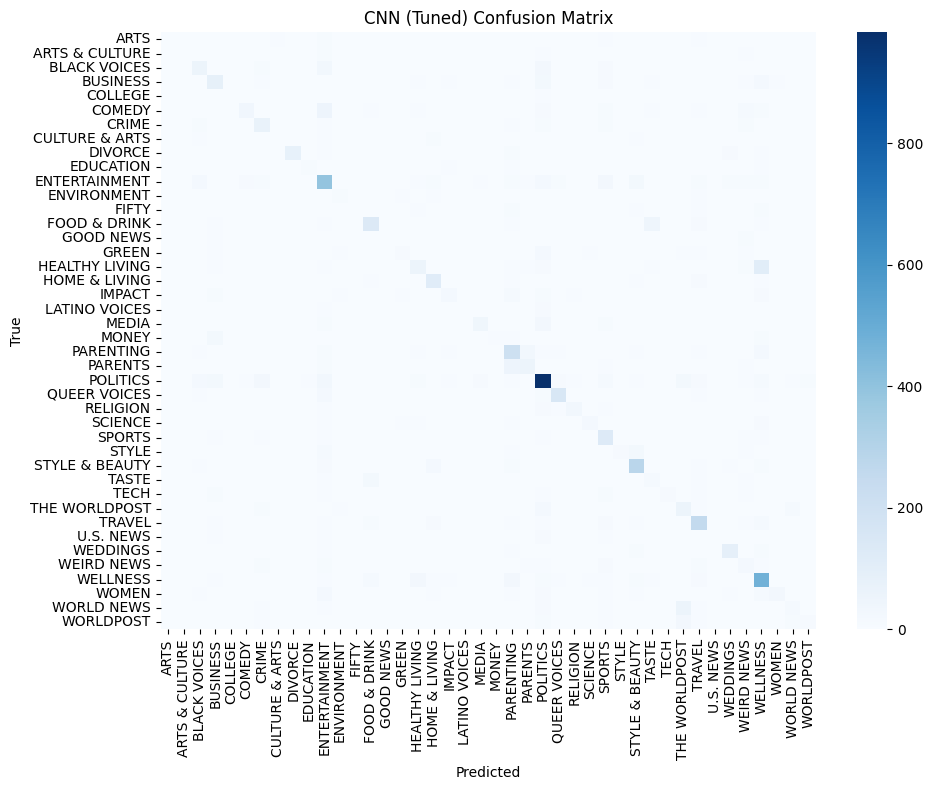

In [39]:
# Choose predictions from the model you want to evaluate
y_pred_svm = best_svm.predict(X_test_pca)
y_pred_cnn_tuned = best_model_tuned.predict(X_test_seq).argmax(axis=1)
y_true = test_df['label']

# Print metrics
print("SVM Accuracy:", accuracy_score(y_true, y_pred_svm))
print("CNN (Tuned) Accuracy:", accuracy_score(y_true, y_pred_cnn_tuned))

print("\nSVM Classification Report:\n", classification_report(y_true, y_pred_svm, target_names=label_encoder.classes_))
print("\nCNN (Tuned) Classification Report:\n", classification_report(y_true, y_pred_cnn_tuned, target_names=label_encoder.classes_))


# Confusion matrix (CNN)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_cnn_tuned),
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues", annot=False)
plt.title("CNN (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 9.2 Display some misclassified examples from the CNN model

In [40]:
# Show some wrong predictions
misclassified = test_df.copy()
misclassified['pred'] = y_pred_cnn_tuned
wrong = misclassified[misclassified['label'] != misclassified['pred']]

# Decode to category names
wrong['true_cat'] = label_encoder.inverse_transform(wrong['label'])
wrong['pred_cat'] = label_encoder.inverse_transform(wrong['pred'])

# Show examples
for i in range(min(5, len(wrong))):
    print(f"\n--- Misclassified Example {i+1} ---")
    print("Text:", wrong.iloc[i]['text'][:300], "...")
    print("True Label:", wrong.iloc[i]['true_cat'])
    print("Predicted Label:", wrong.iloc[i]['pred_cat'])



--- Misclassified Example 1 ---
Text: group start movement honor jacob wetterling boy remain find hope word get wettlerling stand ...
True Label: GOOD NEWS
Predicted Label: POLITICS

--- Misclassified Example 2 ---
Text: cathrine wallenius abramowski journalist remind coconut oil awesome benefit good thing new york people run give moment instance meet cathrine ...
True Label: STYLE & BEAUTY
Predicted Label: WELLNESS

--- Misclassified Example 3 ---
Text: lea michele share bikini photo ...
True Label: ENTERTAINMENT
Predicted Label: STYLE & BEAUTY

--- Misclassified Example 4 ---
Text: chief ban kimoon rule run president south korea announcement unscheduled news conference parliament wednesday ...
True Label: THE WORLDPOST
Predicted Label: WORLD NEWS

--- Misclassified Example 5 ---
Text: privacy recent essay new york times column title ironically ear private live woman discuss virginity ...
True Label: WELLNESS
Predicted Label: SPORTS


C:\Users\marti\AppData\Local\Temp\ipykernel_33800\1851142316.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong['true_cat'] = label_encoder.inverse_transform(wrong['label'])
C:\Users\marti\AppData\Local\Temp\ipykernel_33800\1851142316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong['pred_cat'] = label_encoder.inverse_transform(wrong['pred'])


### 9.3 Create a summary table of model performances

In [41]:
summary = pd.DataFrame({
    "Model": ["SVM (TF-IDF + PCA)", "CNN (Tuned)"],
    "Accuracy": [
        accuracy_score(y_true, y_pred_svm),
        accuracy_score(y_true, y_pred_cnn_tuned)
    ],
    "F1 Score (weighted)": [
        f1_score(y_true, y_pred_svm, average='weighted'),
        f1_score(y_true, y_pred_cnn_tuned, average='weighted')
    ]
})
print("\nModel Performance Summary:\n", summary)


Model Performance Summary:
                 Model  Accuracy  F1 Score (weighted)
0  SVM (TF-IDF + PCA)  0.495333             0.438312
1         CNN (Tuned)  0.534533             0.510684
